In [157]:
from sklearn import svm
from sklearn import linear_model
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import math
import joblib
import copy
from genetic_selection import GeneticSelectionCV

# Read FRED data
djia_stat = {}
news_stat = {}
djia_st = 0

start_date = (datetime.datetime.strptime("2018-11-09", "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()

with open("DJIA.csv", "r") as djia_r:
    djia_r.readline()
    djia_close = []
    for l in djia_r:
        x = l.strip().split(",")
        if x[1] == ".": # Skip days for which there are no values.
            continue
        u = [(datetime.datetime.strptime(x[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds(), djia_close[-1] if len(djia_close) != 0 else float(x[1]), djia_close[-2] if len(djia_close) > 1 else float(x[1])]
        if x[0] == "2018-11-09": # Check this date
            djia_st = len(djia_stat)
        v = float(x[1]) # Output value
        djia_close.append(v)
        djia_stat[u[0]] = u[1:] + [v]

with open("DJIAHeadlines.csv", "r") as headlines_r:
    for l in headlines_r:
        vals = l.split(",")
        news_stat[(datetime.datetime.strptime(vals[0], "%Y-%m-%d") - datetime.datetime(1970, 1, 1)).total_seconds()] = [int(x) for x in vals[1:]]

# Toss out any data before start_date
ks = copy.deepcopy(list(djia_stat.keys()))
for k in ks:
    if k < start_date:
        del djia_stat[k]
    
# Assume these will both be arrays.
def dict_zip(djia, other):
    k = djia.keys() # Only use DJIA keys as it is closed more often than the news
    res = []
    for x in k:
        res.append([x] + other[x] + djia[x])
    return res
        
def fit(djia_s):
    djia_in = []
    djia_out = []
    dat_ = djia_s
    dat = []
    
    dat = dat_
    split = int(.8 * len(dat))

    scaler = MinMaxScaler()
    scaler.fit(dat)
    djia_s = scaler.transform(dat)

    djia_in = [x[:-1] for x in djia_s]
    djia_out = [x[-1] for x in djia_s]

    djia_in_train = np.array(djia_in[:split])
    djia_out_train = np.array(djia_out[:split])
    djia_in_test = np.array(djia_in[split:])
    djia_out_test = np.array(djia_out[split:])

    m = svm.SVR(C=0.01, cache_size=1000, coef0=djia_out_train[-1], degree=5, epsilon=0.001, gamma='auto', kernel='poly', max_iter=5000, shrinking=True, tol=0.0001, verbose=True)

    model = m.fit(djia_in_train, djia_out_train)
    res = copy.deepcopy(m.predict(djia_in_test))

    m2 = GeneticSelectionCV(m, cv=5, verbose=1, scoring="neg_mean_squared_error", n_population=1000, crossover_proba=0.5, mutation_proba=0.2, n_generations=3000, crossover_independent_proba=0.5, mutation_independent_proba=0.05, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=10)
    m2.fit(djia_in_train, djia_out_train)

    res2 = m2.predict(djia_in_test)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(1, len(res)):
        dirres = res[i] - res[i - 1] >= 0
        diract = djia_out_test[i] - djia_out_test[i - 1] >= 0
        if dirres == diract:
            if dirres == True:
                tp += 1
            else:
                tn += 1
        else:
            if dirres == True:
                fp += 1
            else:
                fn += 1

    return (split, djia_out_test, res, res2)

In [168]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 600

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                        	std                            	min              	max                      
0  	1000  	[-190.0181599    2.954    ]	[1.36524470e+03 1.20660018e+00]	[-10000.      0.]	[-0.00847251  6.        ]
1  	594   	[-40.01207623   2.971     ]	[631.18858824   1.11721037]    	[-10000.      0.]	[-0.00847251  6.        ]
2  	591   	[-20.01008077   2.577     ]	[446.76570681   1.0000355 ]    	[-10000.      0.]	[-0.00847251  6.        ]
3  	575   	[-60.00905063   2.033     ]	[772.26867988   0.87972212]    	[-10000.      0.]	[-0.00847251  5.        ]
4  	615   	[-90.00875735   1.524     ]	[9.44403740e+02 7.63821969e-01]	[-10000.      0.]	[-0.00847251  4.        ]
5  	604   	[-80.00854547   1.13      ]	[8.90841531e+02 4.46206230e-01]	[-10000.      0.]	[-0.00847251  4.        ]
6  	587   	[-100.00845318    1.04      ]	[9.94986588e+02 2.61533937e-01]	[-10000.      0.]	[-0.00847251  3.        ]
7  	568   	[-130.00846823  

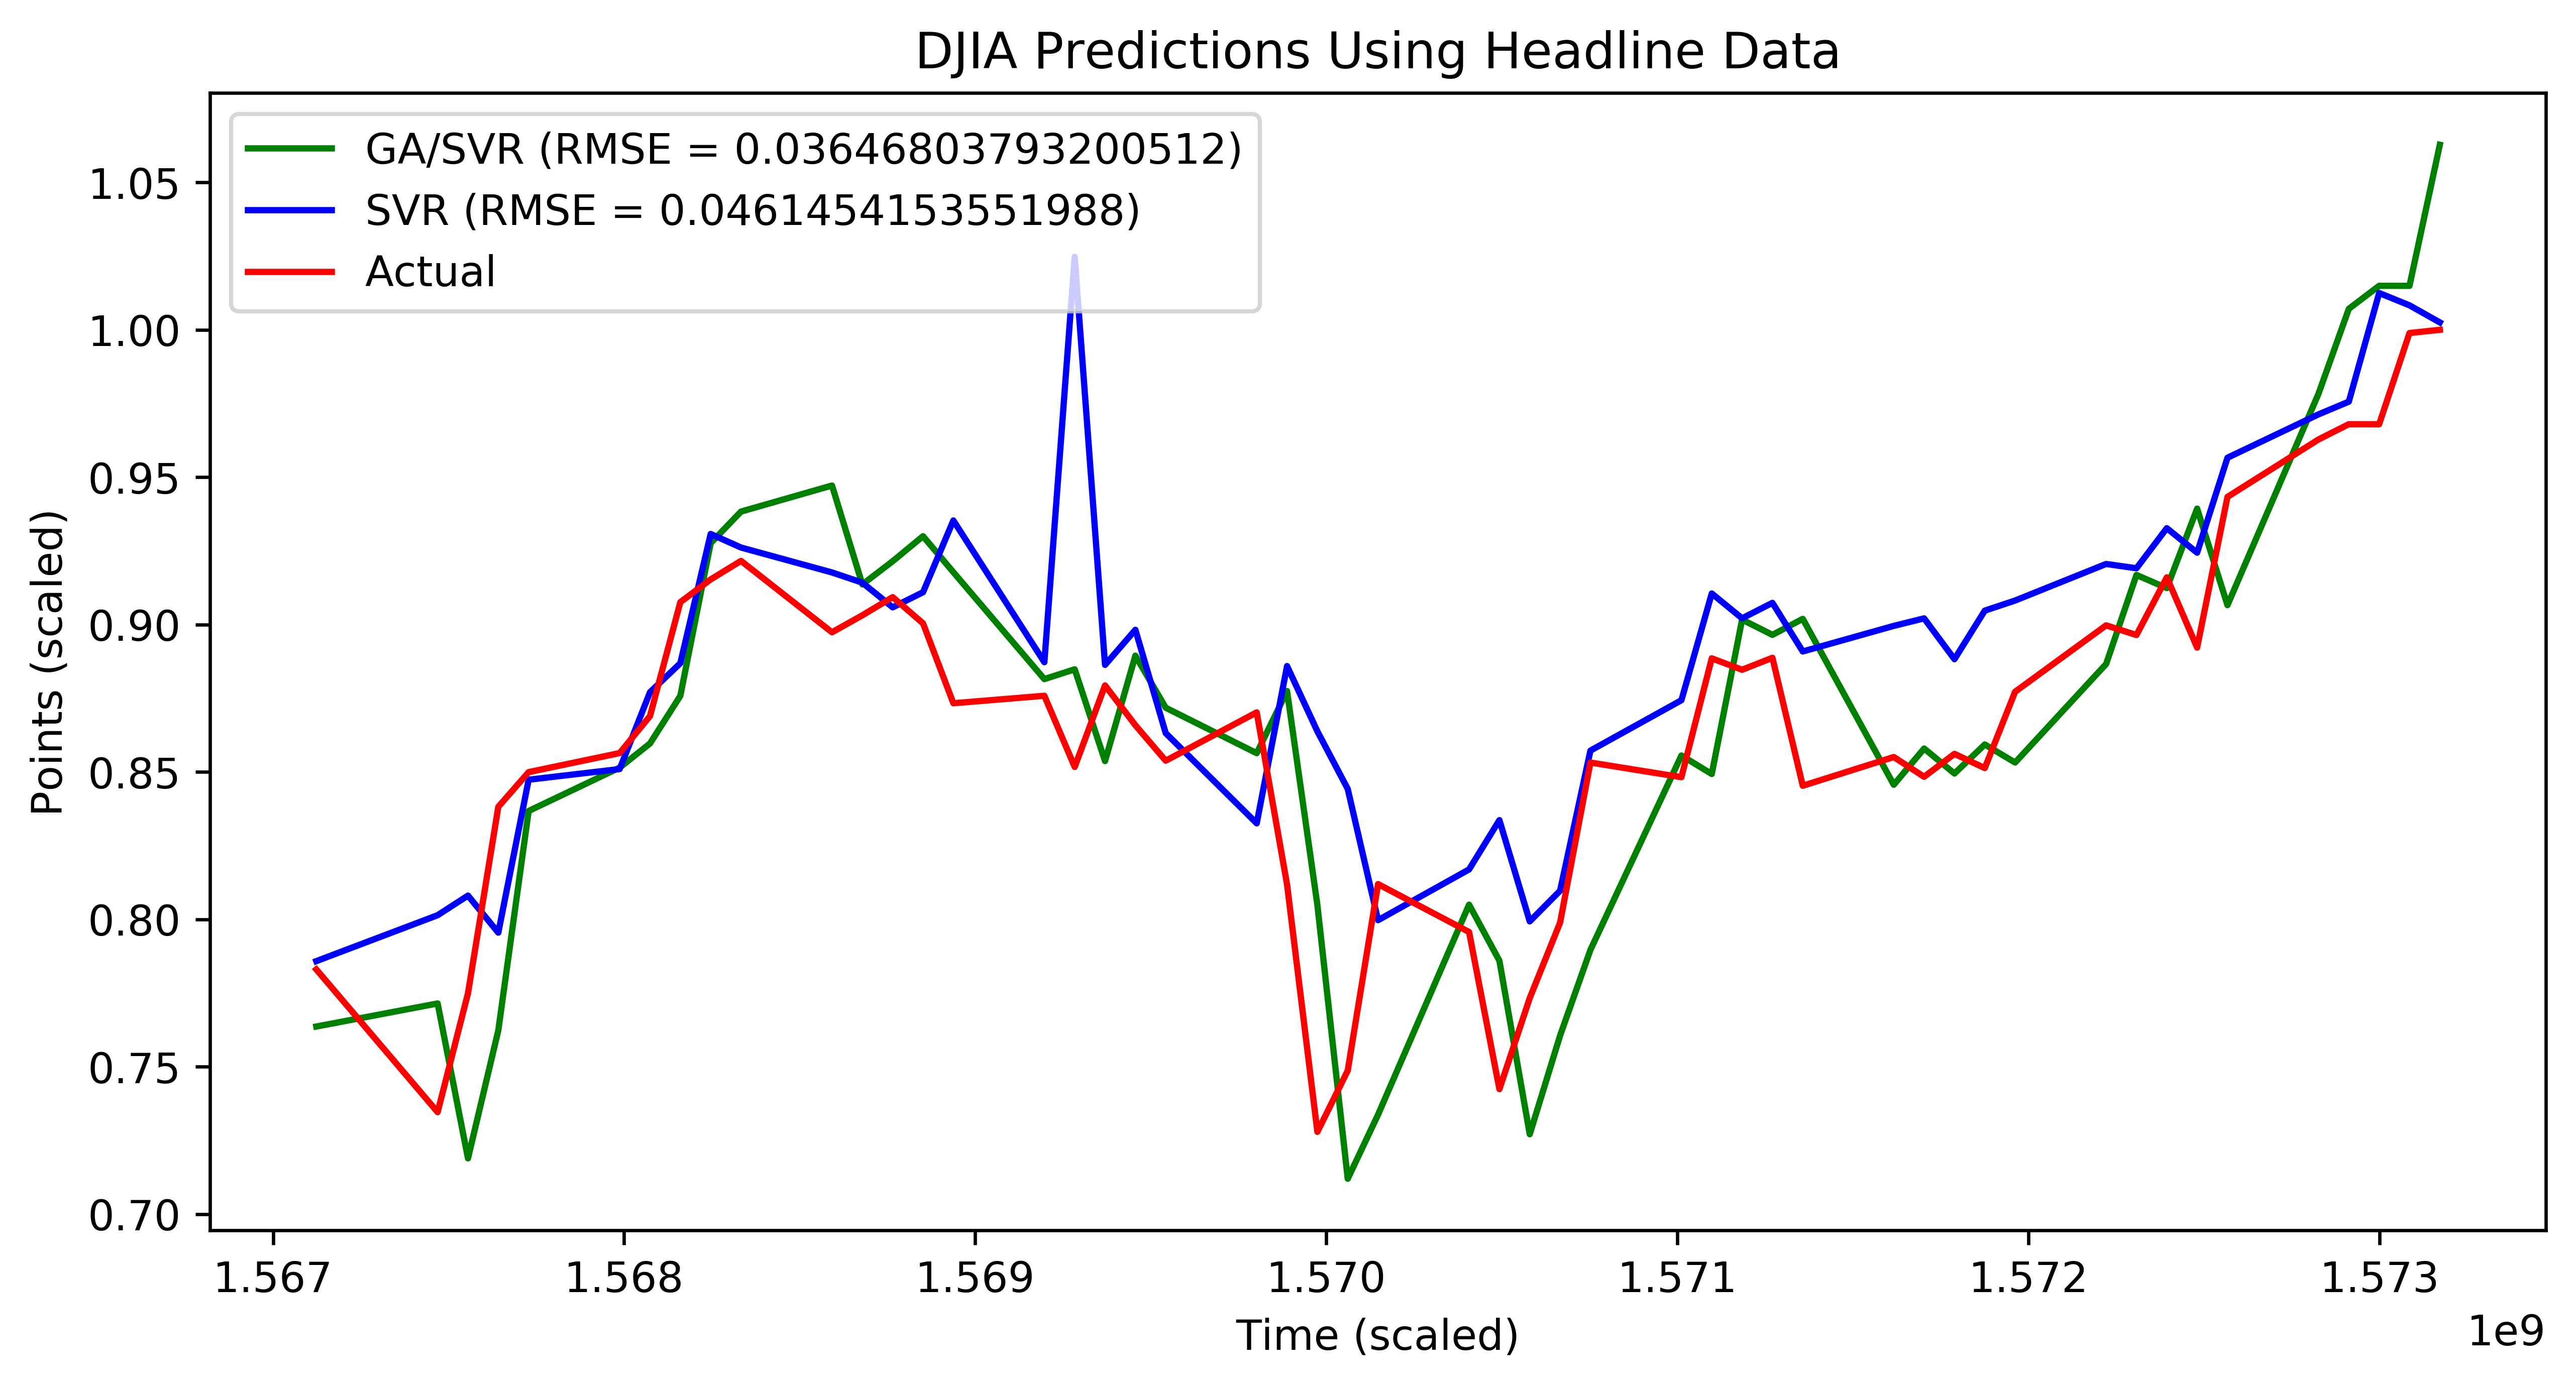

In [169]:
inp = dict_zip(djia_stat, news_stat)
split, actual, res, resga = fit(inp)
xs = [x[0] for x in inp[split:]]
plt.plot(xs, resga, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga))) + ")")
plt.plot(xs, res, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Headline Data")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-380.01614194    2.51      ]	[1.91195913e+03 1.12867179e+00]	[-10000.      0.]	[-0.00847251  5.        ]
1  	590   	[-50.01151604   2.619     ]  	[705.33598265   1.02070515]    	[-10000.      0.]	[-0.00847251  5.        ]
2  	598   	[-30.00975799   2.253     ]  	[546.89982129   0.89386296]    	[-10000.      0.]	[-0.00847251  5.        ]
3  	583   	[-30.00898633   1.669     ]  	[546.89986362   0.69529778]    	[-10000.      0.]	[-0.00847251  5.        ]
4  	595   	[-30.00864477   1.205     ]  	[5.46899882e+02 4.27755771e-01]	[-10000.      0.]	[-0.00847251  3.        ]
5  	632   	[-130.00849918    1.042     ]	[1.13273907e+03 2.72462842e-01]	[-10000.      0.]	[-0.00847251  3.        ]
6  	626   	[-80.00854189   1.029     ]  	[8.90841531e+02 2.23962050e-01]	[-10000.      0.]	[-0.00847251  3.        ]
7  	549   	[-

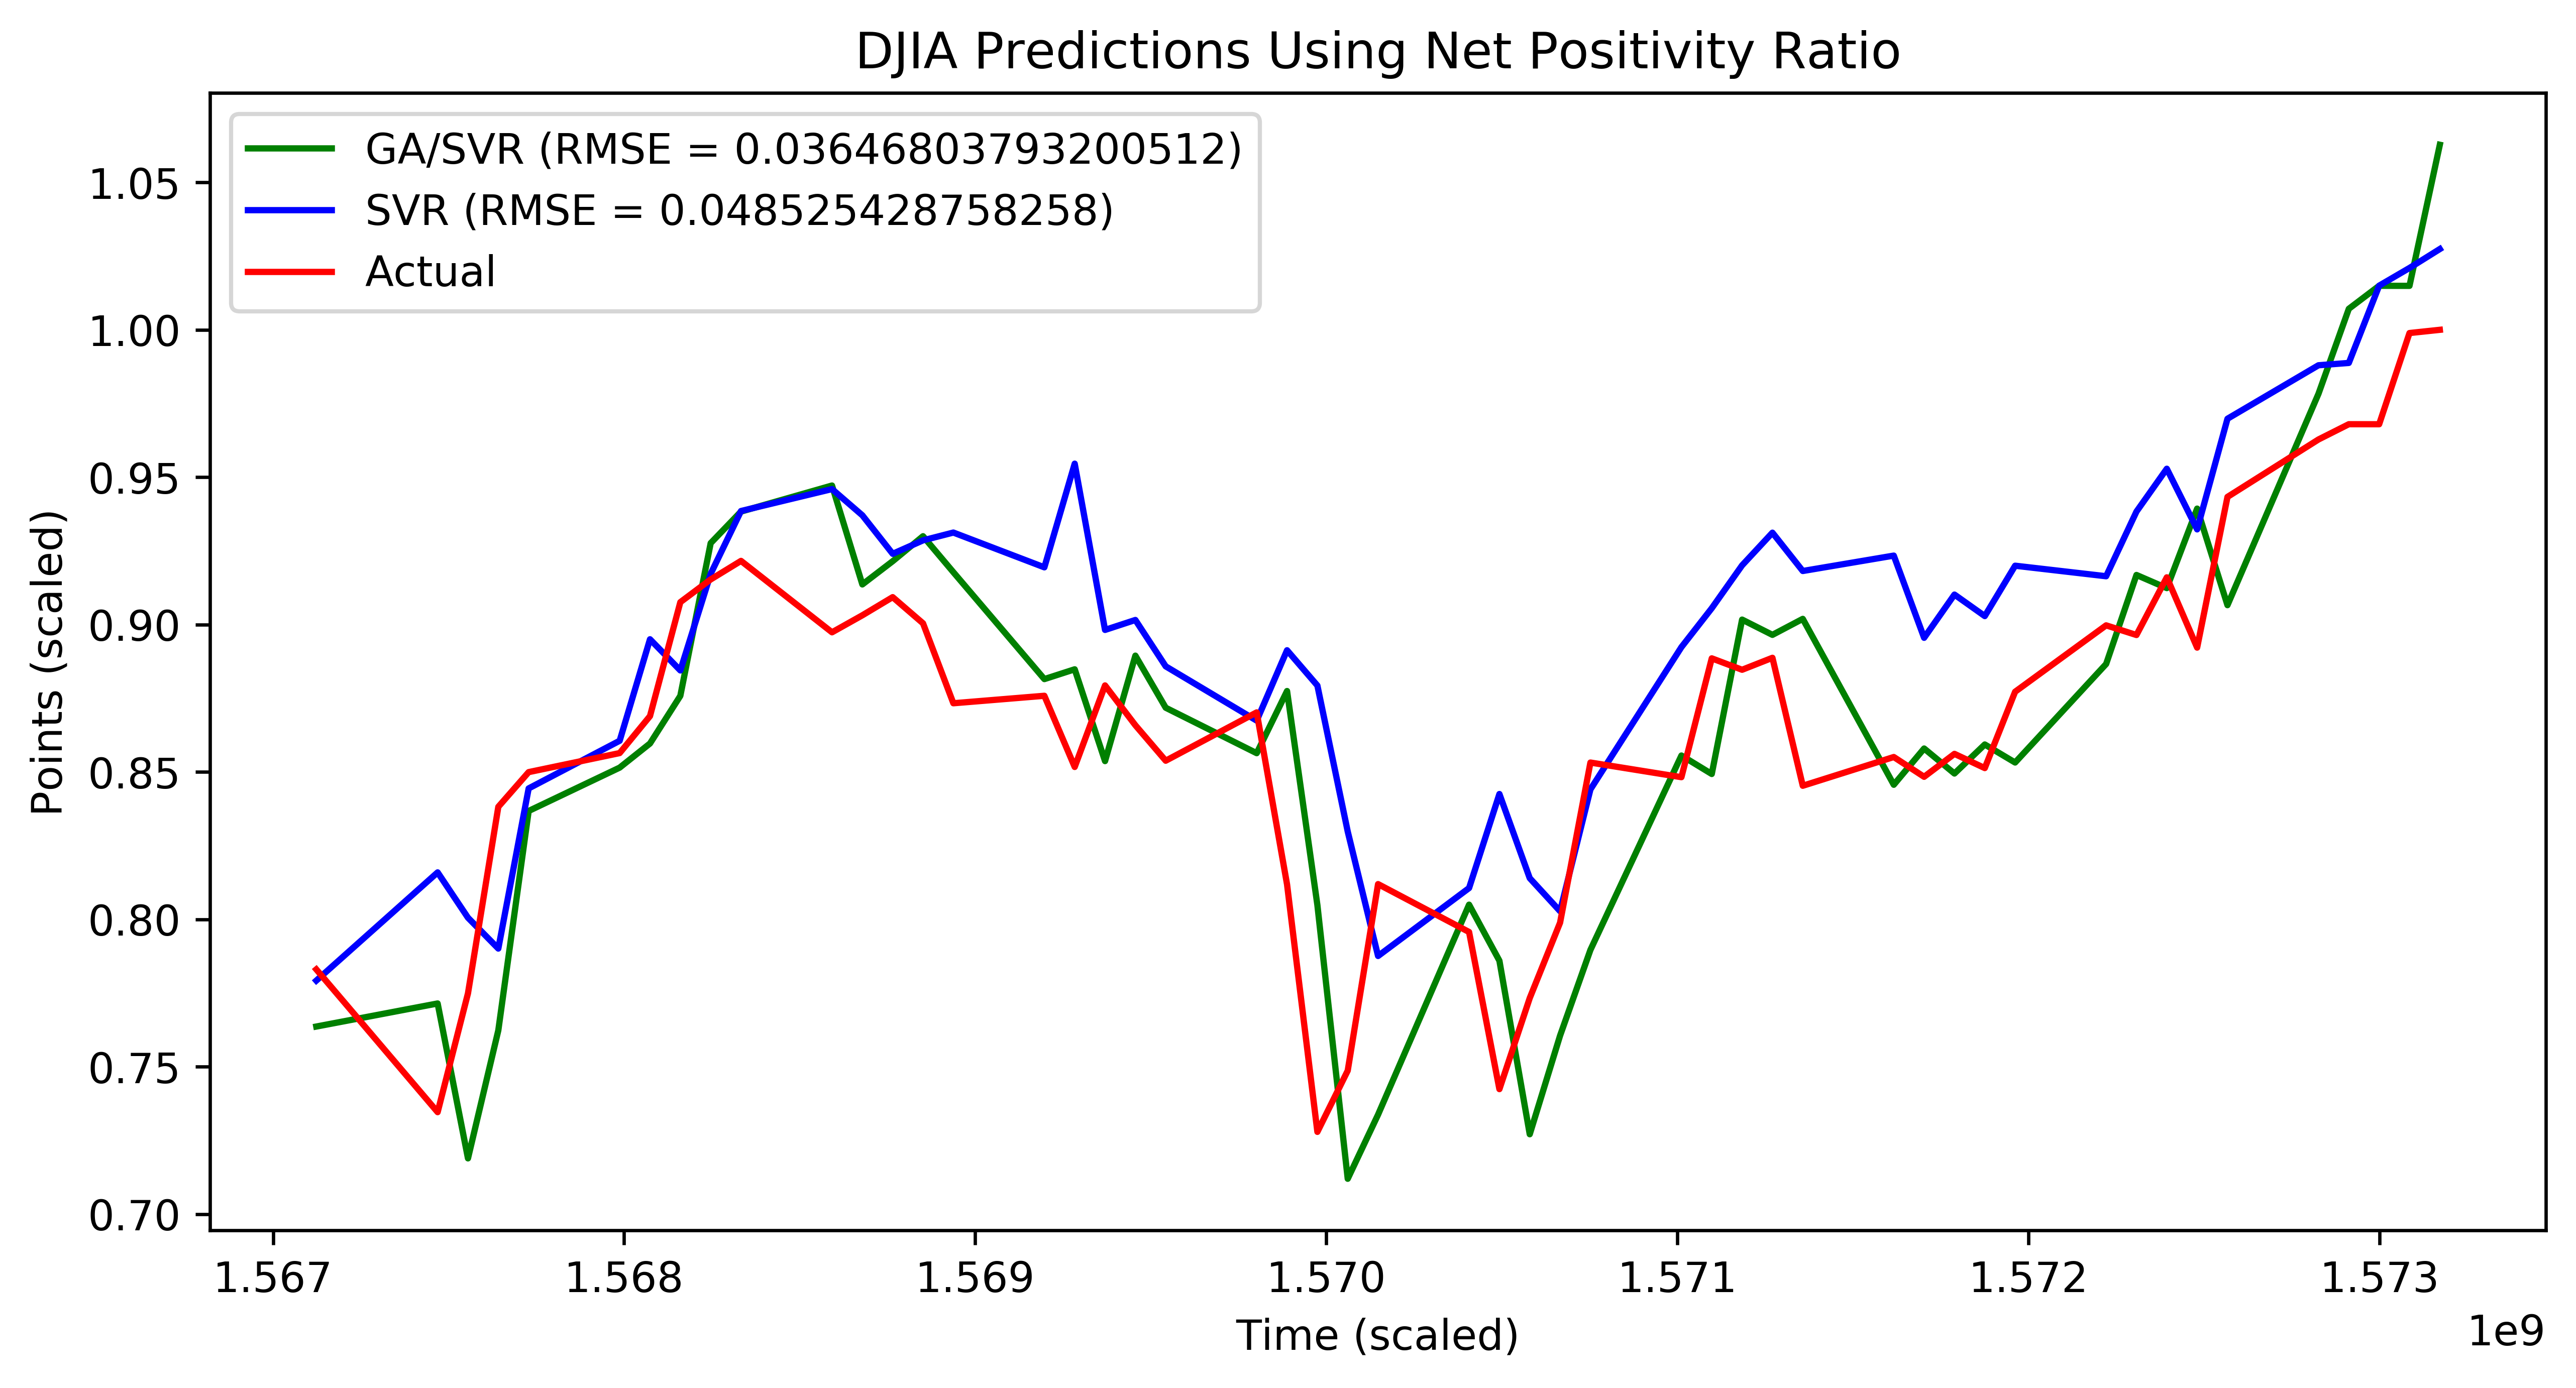

In [171]:
news_stat_ratio = {}
for k, v in news_stat.items():
    news_stat_ratio[k] = [news_stat[k][0], (news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0])]
    
inp2 = dict_zip(djia_stat, news_stat_ratio)
split, actual, res2, resga2 = fit(inp2)
xs = [x[0] for x in inp2[split:]]
plt.plot(xs, resga2, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga2))) + ")")
plt.plot(xs, res2, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res2))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Net Positivity Ratio")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                          	std                            	min              	max                      
0  	1000  	[-290.01590052    2.582     ]	[1.67806161e+03 1.11142971e+00]	[-10000.      0.]	[-0.00847251  5.        ]
1  	611   	[-60.01144485   2.667     ]  	[772.26849388   1.01691248]    	[-10000.      0.]	[-0.00847251  5.        ]
2  	643   	[-30.00971029   2.342     ]  	[546.89982391   0.88489321]    	[-10000.      0.]	[-0.00847251  5.        ]
3  	614   	[-50.00902588   1.807     ]  	[705.33615916   0.76141382]    	[-10000.      0.]	[-0.00847251  4.        ]
4  	574   	[-60.00870676   1.257     ]  	[7.72268707e+02 4.86776129e-01]	[-10000.      0.]	[-0.00847251  4.        ]
5  	603   	[-100.00848478    1.052     ]	[9.94986584e+02 2.70732340e-01]	[-10000.      0.]	[-0.00847251  3.        ]
6  	597   	[-50.00852096   1.034     ]  	[7.05336195e+02 2.21006787e-01]	[-10000.      0.]	[-0.00847251  3.        ]
7  	627   	[-

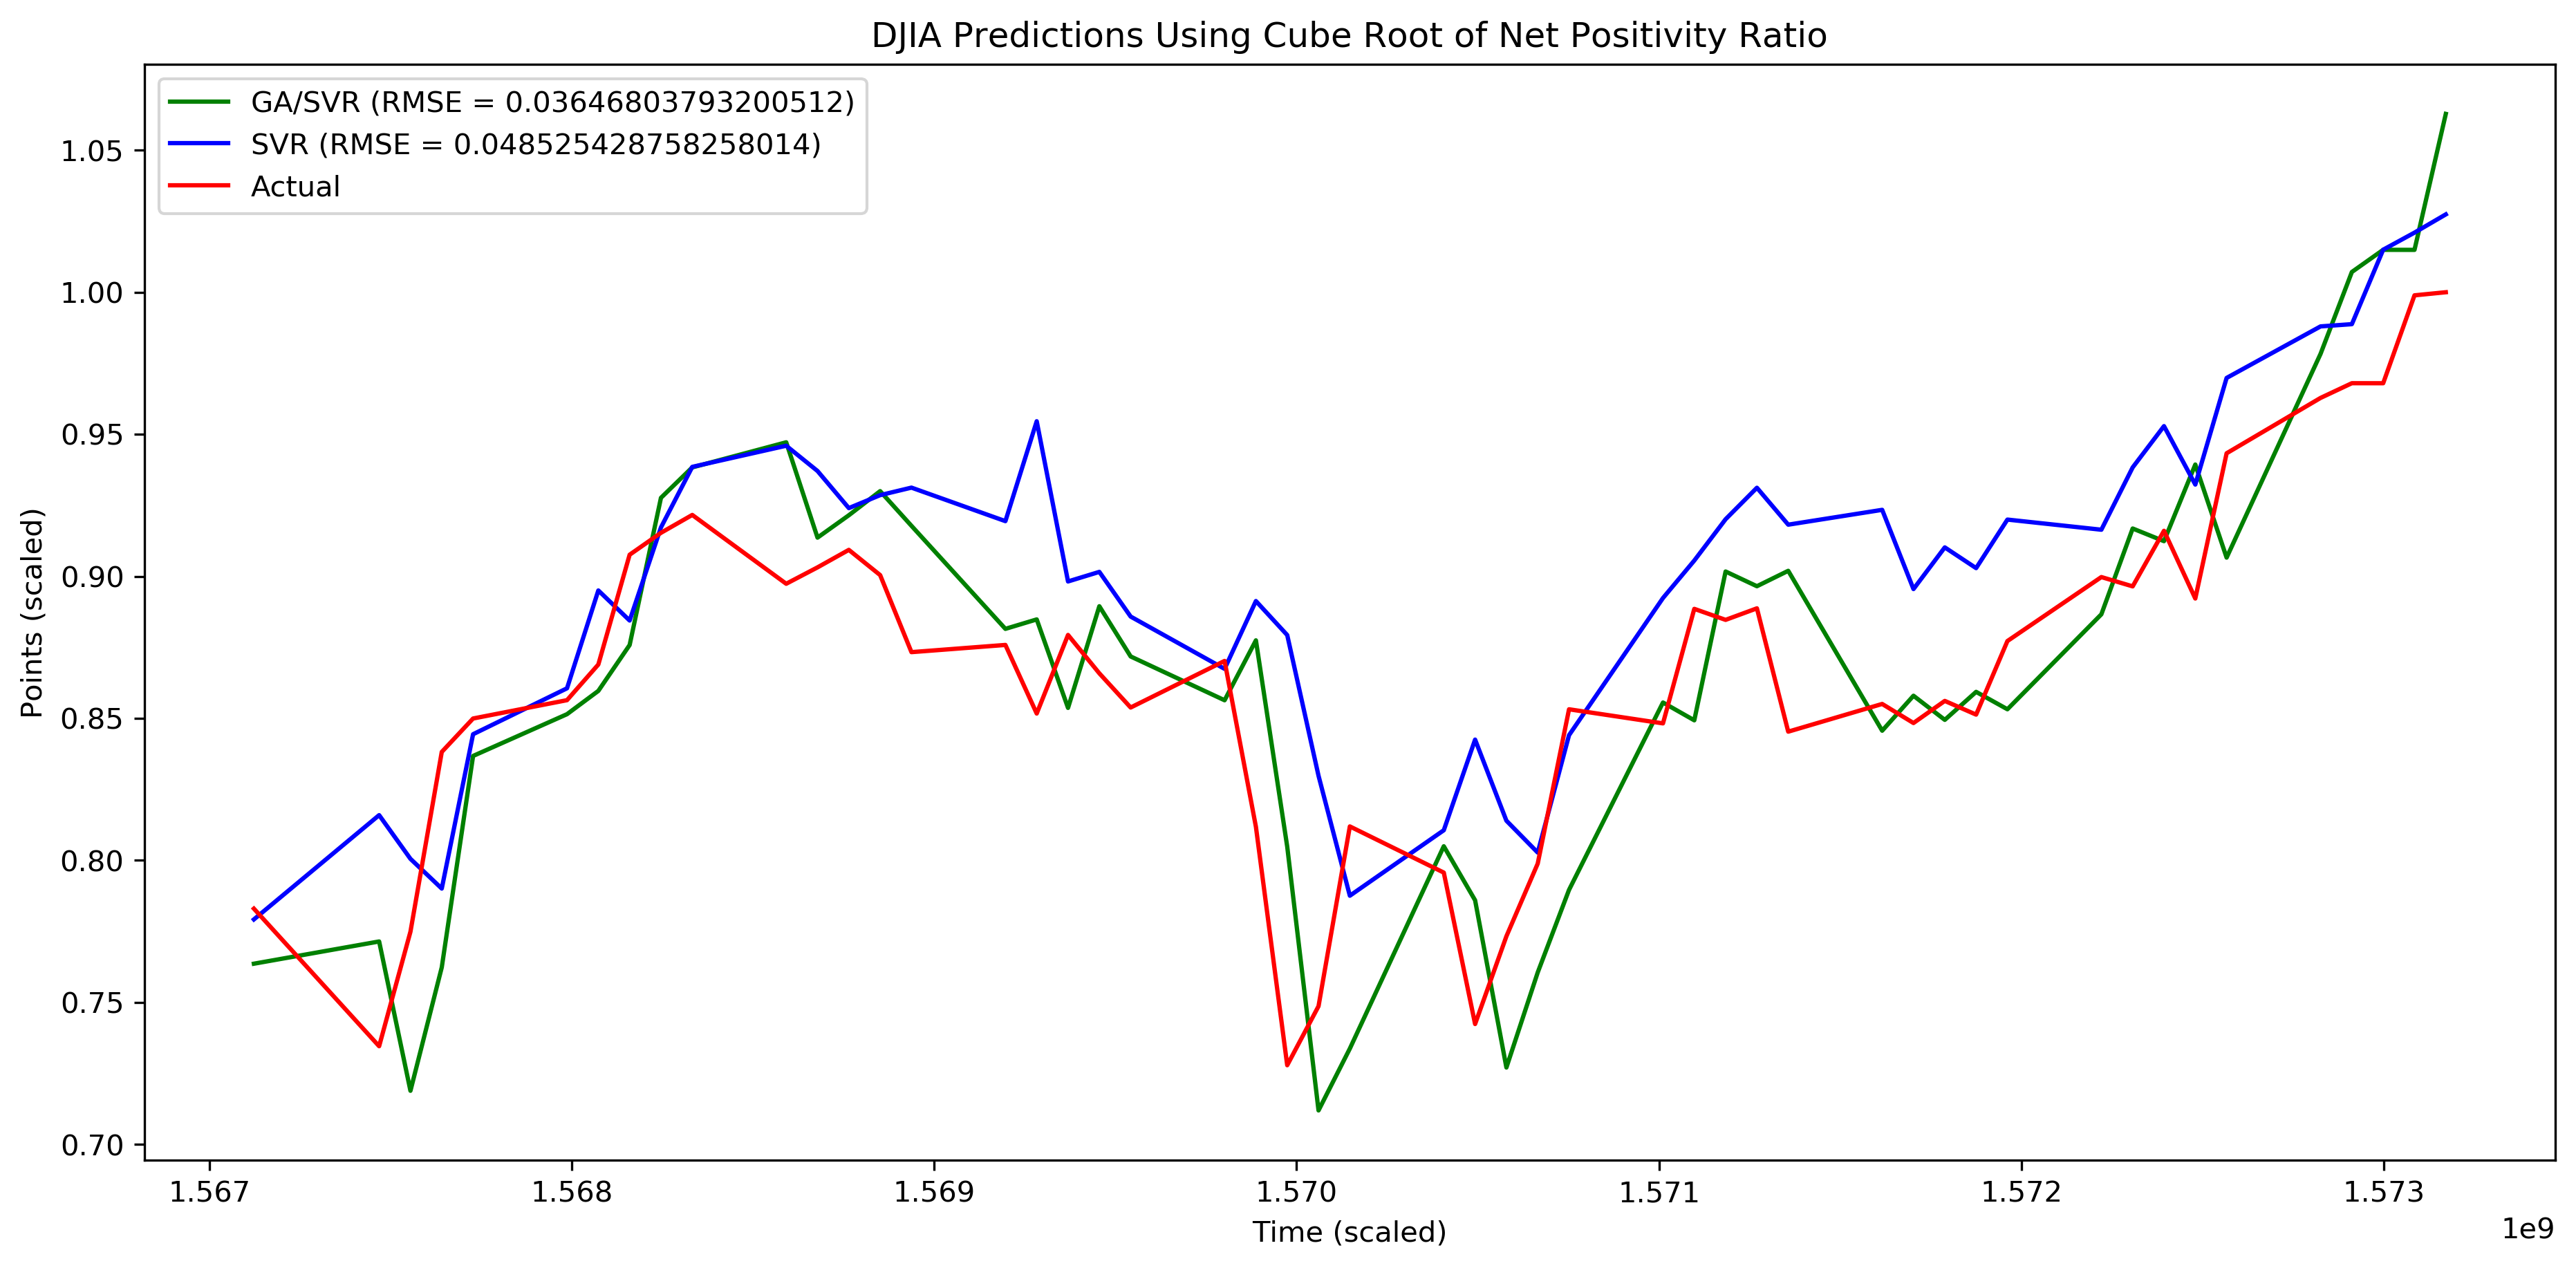

In [150]:
news_stat_ratio_2 = {}
for k, v in news_stat.items():
    news_stat_ratio_2[k] = [news_stat[k][0], ((news_stat[k][1] - news_stat[k][2]) / (news_stat[k][0]) ** 1/3)]
    
inp3 = dict_zip(djia_stat, news_stat_ratio_2)
split, actual, res3, resga3 = fit(inp3)
xs = [x[0] for x in inp3[split:]]
plt.plot(xs, resga3, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga3))) + ")")
plt.plot(xs, res3, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res3))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Using Cube Root of Net Positivity Ratio")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()

[LibSVM]Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min              	max                      
0  	1000  	[-1180.01113174     1.522     ]	[3.22607714e+03 8.62273738e-01]	[-10000.      0.]	[-0.00847251  3.        ]
1  	603   	[-190.00965845    1.682     ]  	[1.36524589e+03 7.50250625e-01]	[-10000.      0.]	[-0.00847251  3.        ]
2  	585   	[-60.00872486   1.34      ]    	[7.72268705e+02 5.74804315e-01]	[-10000.      0.]	[-0.00847251  3.        ]
3  	589   	[-110.00843238    1.039     ]  	[1.04302356e+03 2.51950392e-01]	[-10000.      0.]	[-0.00847251  3.        ]
4  	590   	[-70.00843832   1.009     ]    	[8.33725865e+02 1.51390224e-01]	[-10000.      0.]	[-0.00847251  2.        ]
5  	615   	[-130.00838259    1.        ]  	[1.13273908e+03 1.61245155e-01]	[-10000.      0.]	[-0.00847251  2.        ]
6  	627   	[-70.00846375   1.016     ]    	[8.33725863e+02 1.72464489e-01]	[-10000.      0.]	[-0.00847251  2.       

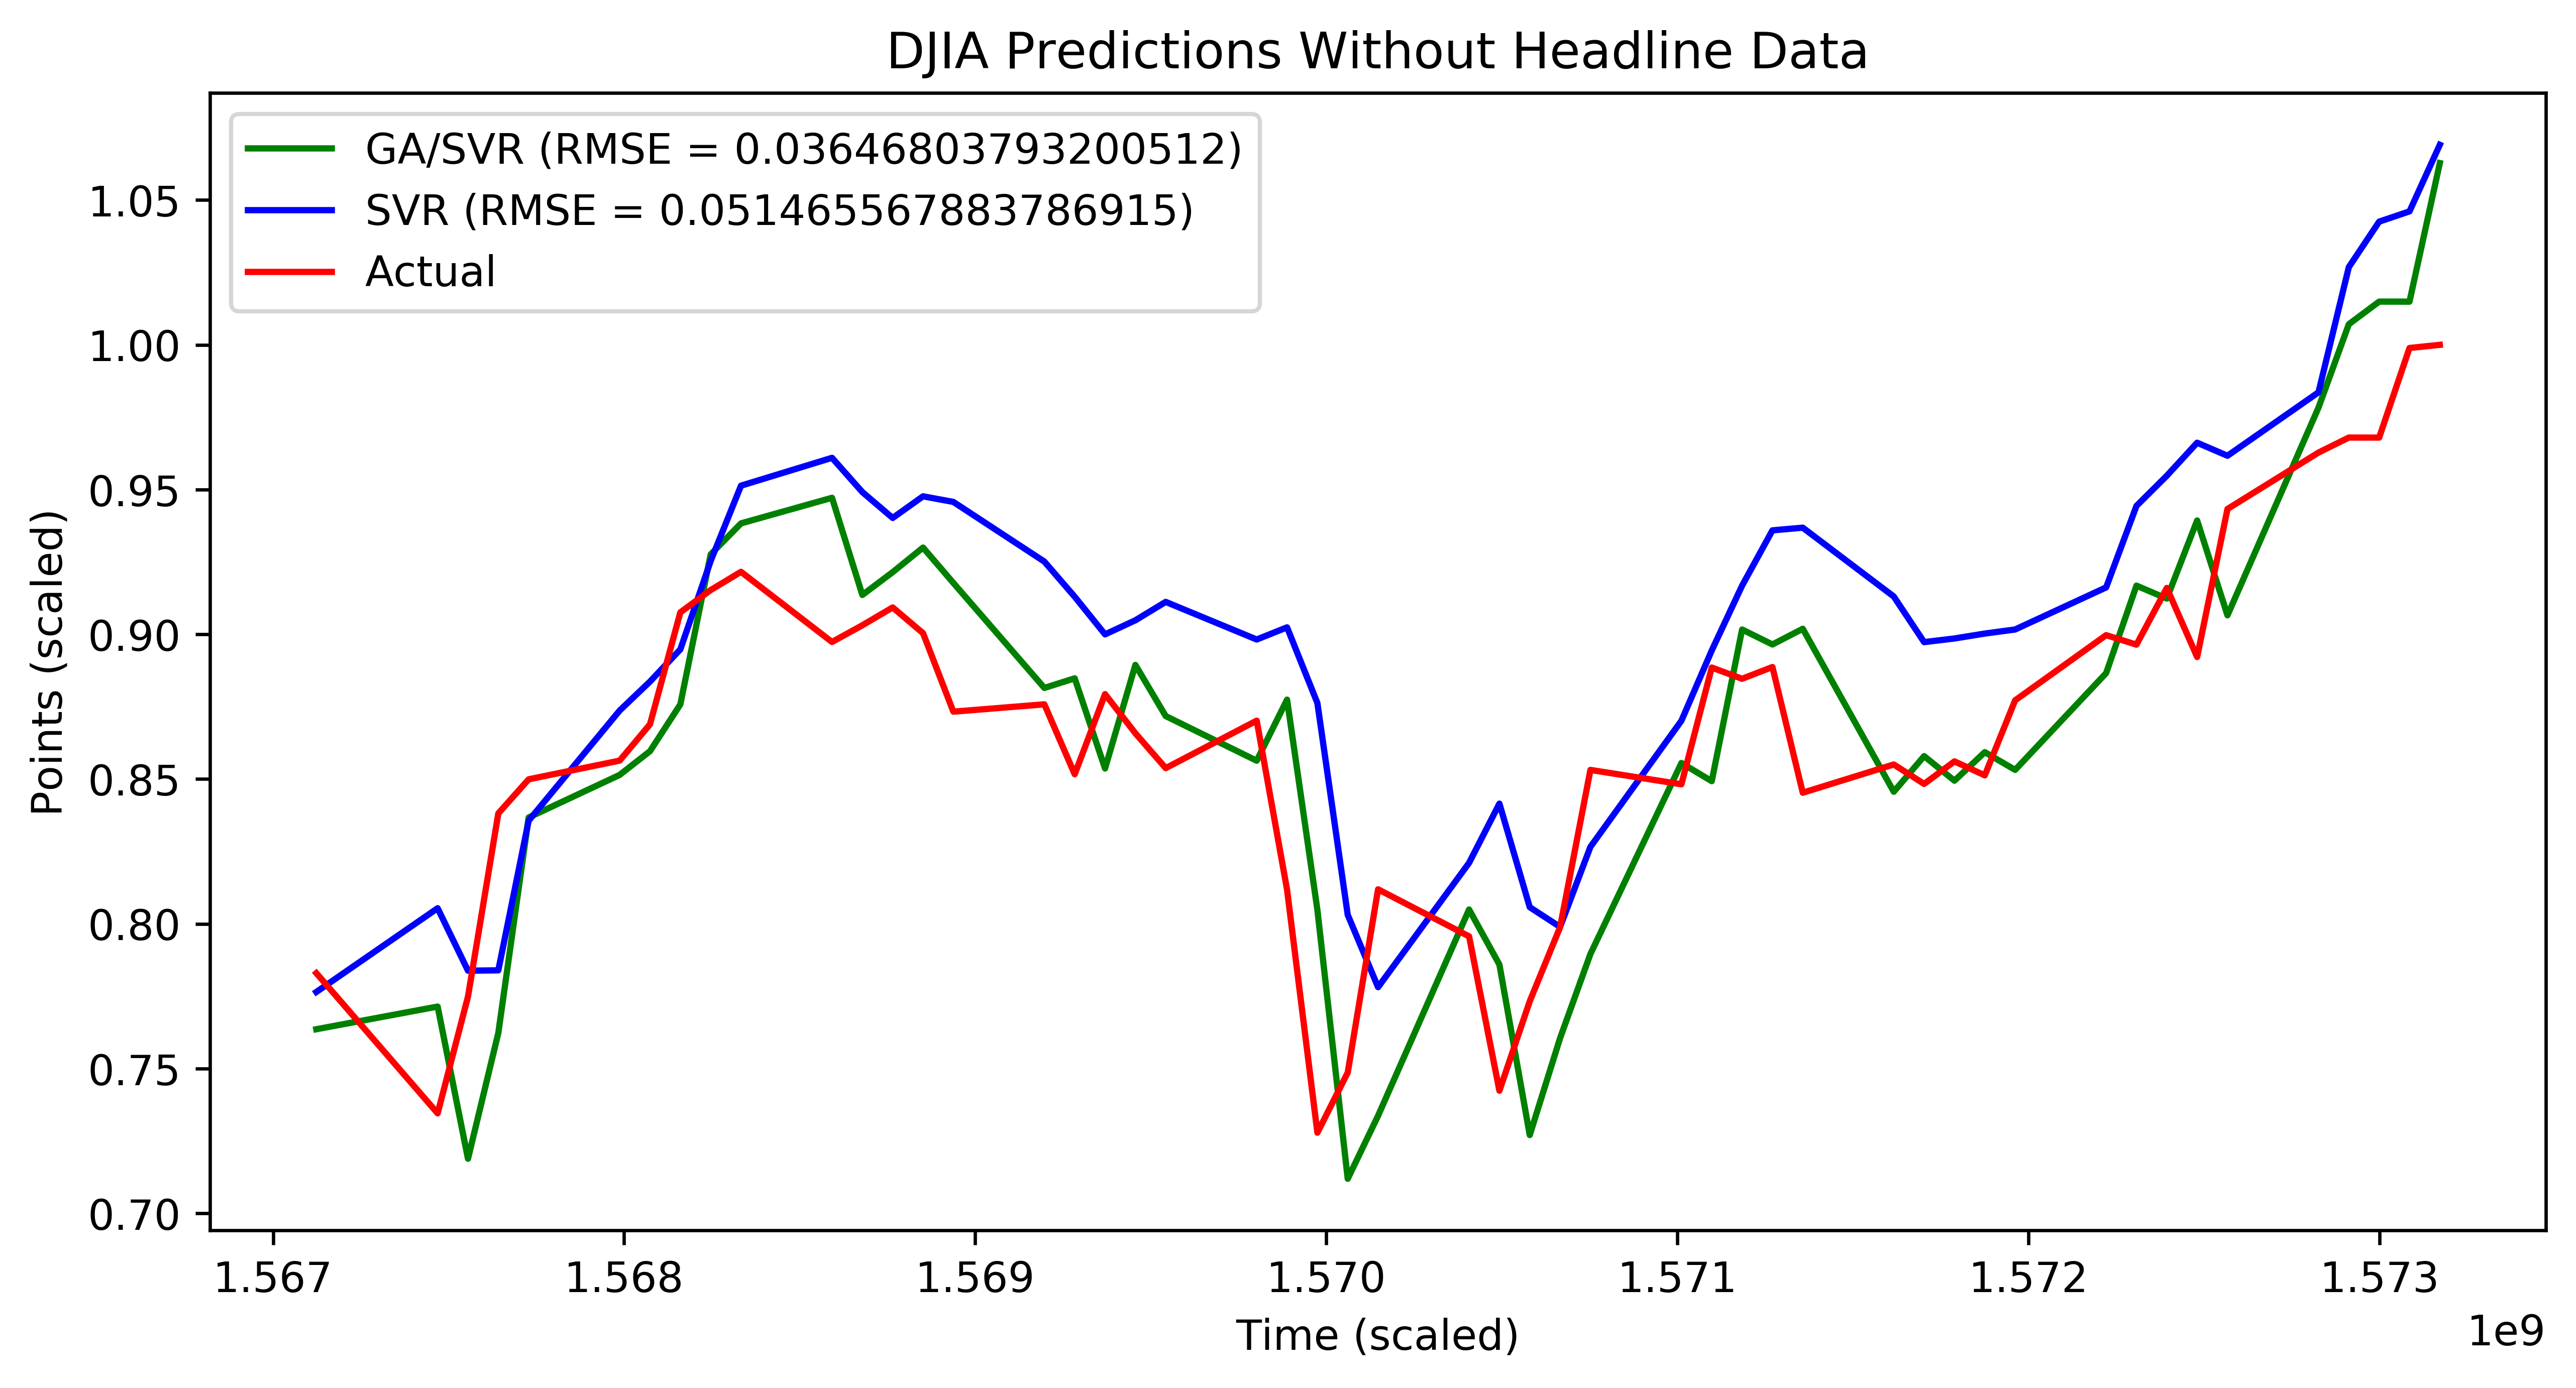

In [172]:
control = {}
for k, v in news_stat.items():
    control[k] = []
    
inp4 = dict_zip(djia_stat, control)
split, actual, res4, resga4 = fit(inp4)
xs = [x[0] for x in inp4[split:]]
plt.plot(xs, resga4, "g", label="GA/SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, resga4))) + ")")
plt.plot(xs, res4, "b", label="SVR (RMSE = " + str(math.sqrt(mean_squared_error(actual, res4))) + ")")
plt.plot(xs, actual, "r", label="Actual")
plt.title("DJIA Predictions Without Headline Data")
plt.xlabel('Time (scaled)')
plt.ylabel('Points (scaled)')
plt.legend()